In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.isotonic import IsotonicRegression
from pygam import LogisticGAM, s
from scipy.stats import gaussian_kde

In [75]:
input_target = "output/run1/splinePEP/0/peptide.target.txt"
input_decoy = "output/run1/splinePEP/0/peptide.decoy.txt"
columns = ["score", "q-value", "posterior_error_prob"]
df_target = pd.read_csv(input_target, sep="\t", usecols=columns)
df_decoy = pd.read_csv(input_decoy, sep="\t", usecols=columns)
df_target["type"] = int(0)
df_decoy["type"] = int(1)
df = pd.concat([df_target, df_decoy], ignore_index=True)
df = df.sort_values(by='score', ascending=False, ignore_index=True)
df = df.rename(columns={"posterior_error_prob": "pep_percspline"})
x = np.array(range(len(df["score"])))
x_2d = x.reshape(-1, 1)
y = df["type"].values

y_series = pd.Series(y)
window_size = 500
y_moving_avg = y_series.rolling(window_size, center=True).mean()

decoy_scores = df_decoy["score"].values
kde_decoy = gaussian_kde(decoy_scores, bw_method='scott')

target_scores = df_target["score"].values
kde_target = gaussian_kde(target_scores, bw_method='scott')

all_scores = df["score"].values
kde_all = gaussian_kde(all_scores, bw_method='scott')

pdf_decoy = kde_decoy.evaluate(df["score"].values)
pdf_target = kde_target.evaluate(df["score"].values)
pdf_all   = kde_all.evaluate(df["score"].values)

df["pdf_decoy"] = pdf_decoy
df["pdf_target"] = pdf_target
df["pdf_all"]   = pdf_all
df["pdf_ratio"] = df["pdf_decoy"] / df["pdf_target"]

n_targets = len(df[df["type"] == 0])
n_decoys = len(df[df["type"] == 1])
total = n_targets + n_decoys
prior_decoy = n_decoys / total

In [81]:
df['cum_type'] = df['type'].cumsum()
df['rows_above'] = df.index+1
new_pdf_ratio = (df['pdf_decoy'] + 0.5 * df['rows_above']) / df['rows_above']
mask = df['score'] >= 0.2
df["pdf_ratio_adj"] = df["pdf_ratio"]
df.loc[mask, 'pdf_ratio_adj'] = new_pdf_ratio[mask]

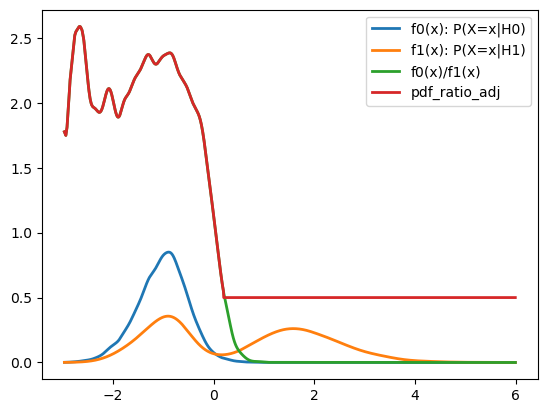

In [82]:
plt.figure()
plt.plot(df['score'], df["pdf_decoy"], label="f0(x): P(X=x|H0)", linewidth=2)
plt.plot(df['score'], df["pdf_target"], label="f1(x): P(X=x|H1)", linewidth=2)
plt.plot(df['score'], df["pdf_ratio"], label="f0(x)/f1(x)", linewidth=2)
plt.plot(df['score'], df["pdf_ratio_adj"], label="pdf_ratio_adj", linewidth=2)
plt.legend()

In [41]:
df

,score,q-value,pep_percspline,type,pdf_decoy,pdf_target,pdf_all,pdf_ratio,pep_isoreg,pdf_ratio_isoreg,pep_logisticgam,q_isoreg,q_logisticgam,q_percspline
3,5.99006,0.000066,1.478370e-17,0,0.000000,0.000152,0.000104,0.000000,0.0,0.000000,0.0,0.000000,0.000000,4.927900e-18
4,5.87565,0.000066,3.131940e-17,0,0.000000,0.000213,0.000144,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.152577e-17
5,5.69785,0.000066,1.005810e-16,0,0.000000,0.000308,0.000213,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.933682e-17
6,5.60379,0.000066,1.864560e-16,0,0.000000,0.000351,0.000242,0.000000,0.0,0.000000,0.0,0.000000,0.000000,5.552335e-17
7,5.54252,0.000066,2.787290e-16,0,0.000000,0.000379,0.000254,0.000000,0.0,0.000000,0.0,0.000000,0.000000,8.740987e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48946,-2.84910,0.469485,1.000000e+00,0,0.002857,0.001312,0.002200,2.177250,1.0,2.447263,1.0,0.304452,0.302711,3.090249e-01
48948,-2.85962,0.469485,1.000000e+00,0,0.002617,0.001240,0.002077,2.109931,1.0,2.447263,1.0,0.304460,0.302719,3.090327e-01
48949,-2.91006,0.469485,1.000000e+00,0,0.001707,0.000942,0.001564,1.811997,1.0,2.447263,1.0,0.304475,0.302733,3.090468e-01
48950,-2.93368,0.469485,1.000000e+00,0,0.001444,0.000826,0.001365,1.748937,1.0,2.447263,1.0,0.304489,0.302747,3.090609e-01


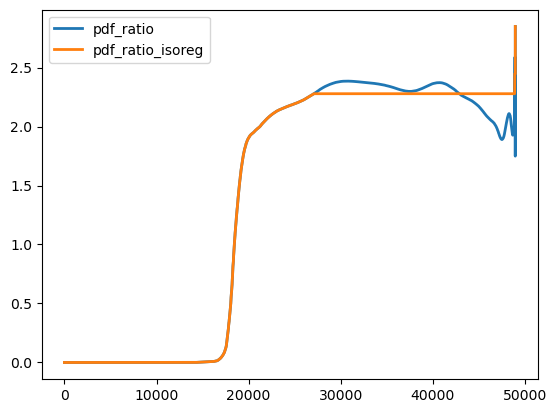

In [77]:
# plt.plot(x, df["pdf_ratio_adj"], label="pdf_ratio_adj", linewidth=2)
plt.plot(x, df["pdf_ratio"], label="pdf_ratio", linewidth=2)
iso_reg = IsotonicRegression(increasing=True)
df["pdf_ratio_isoreg"] = iso_reg.fit_transform(x, df["pdf_ratio"])
plt.plot(x, df["pdf_ratio_isoreg"], label="pdf_ratio_isoreg", linewidth=2)
plt.legend()

In [ ]:
# iso_reg = IsotonicRegression(y_max=1.0, y_min=0.0, increasing=True, out_of_bounds="clip")
# df["pep_isoreg"] = iso_reg.fit_transform(np.array(range(len(df["pdf_ratio"]))), df["pdf_ratio"])

In [78]:
iso_reg = IsotonicRegression(y_max=1.0, y_min=0.0, increasing=True, out_of_bounds="clip")
df["pep_isoreg"] = iso_reg.fit_transform(x, y)
df["pep_isoreg"] = df["pep_isoreg"] * df["pdf_ratio_isoreg"]
# df["pep_isoreg"] = np.clip(df["pep_isoreg"], 0, 1)
gam = LogisticGAM(s(0, constraints='monotonic_inc')).fit(x_2d, y)
df["pep_logisticgam"] = gam.predict_proba(x_2d)
df["pep_logisticgam"] = df["pep_logisticgam"] * df["pdf_ratio_isoreg"]
# df["pep_logisticgam"] = np.clip(df["pep_logisticgam"], 0, 1)

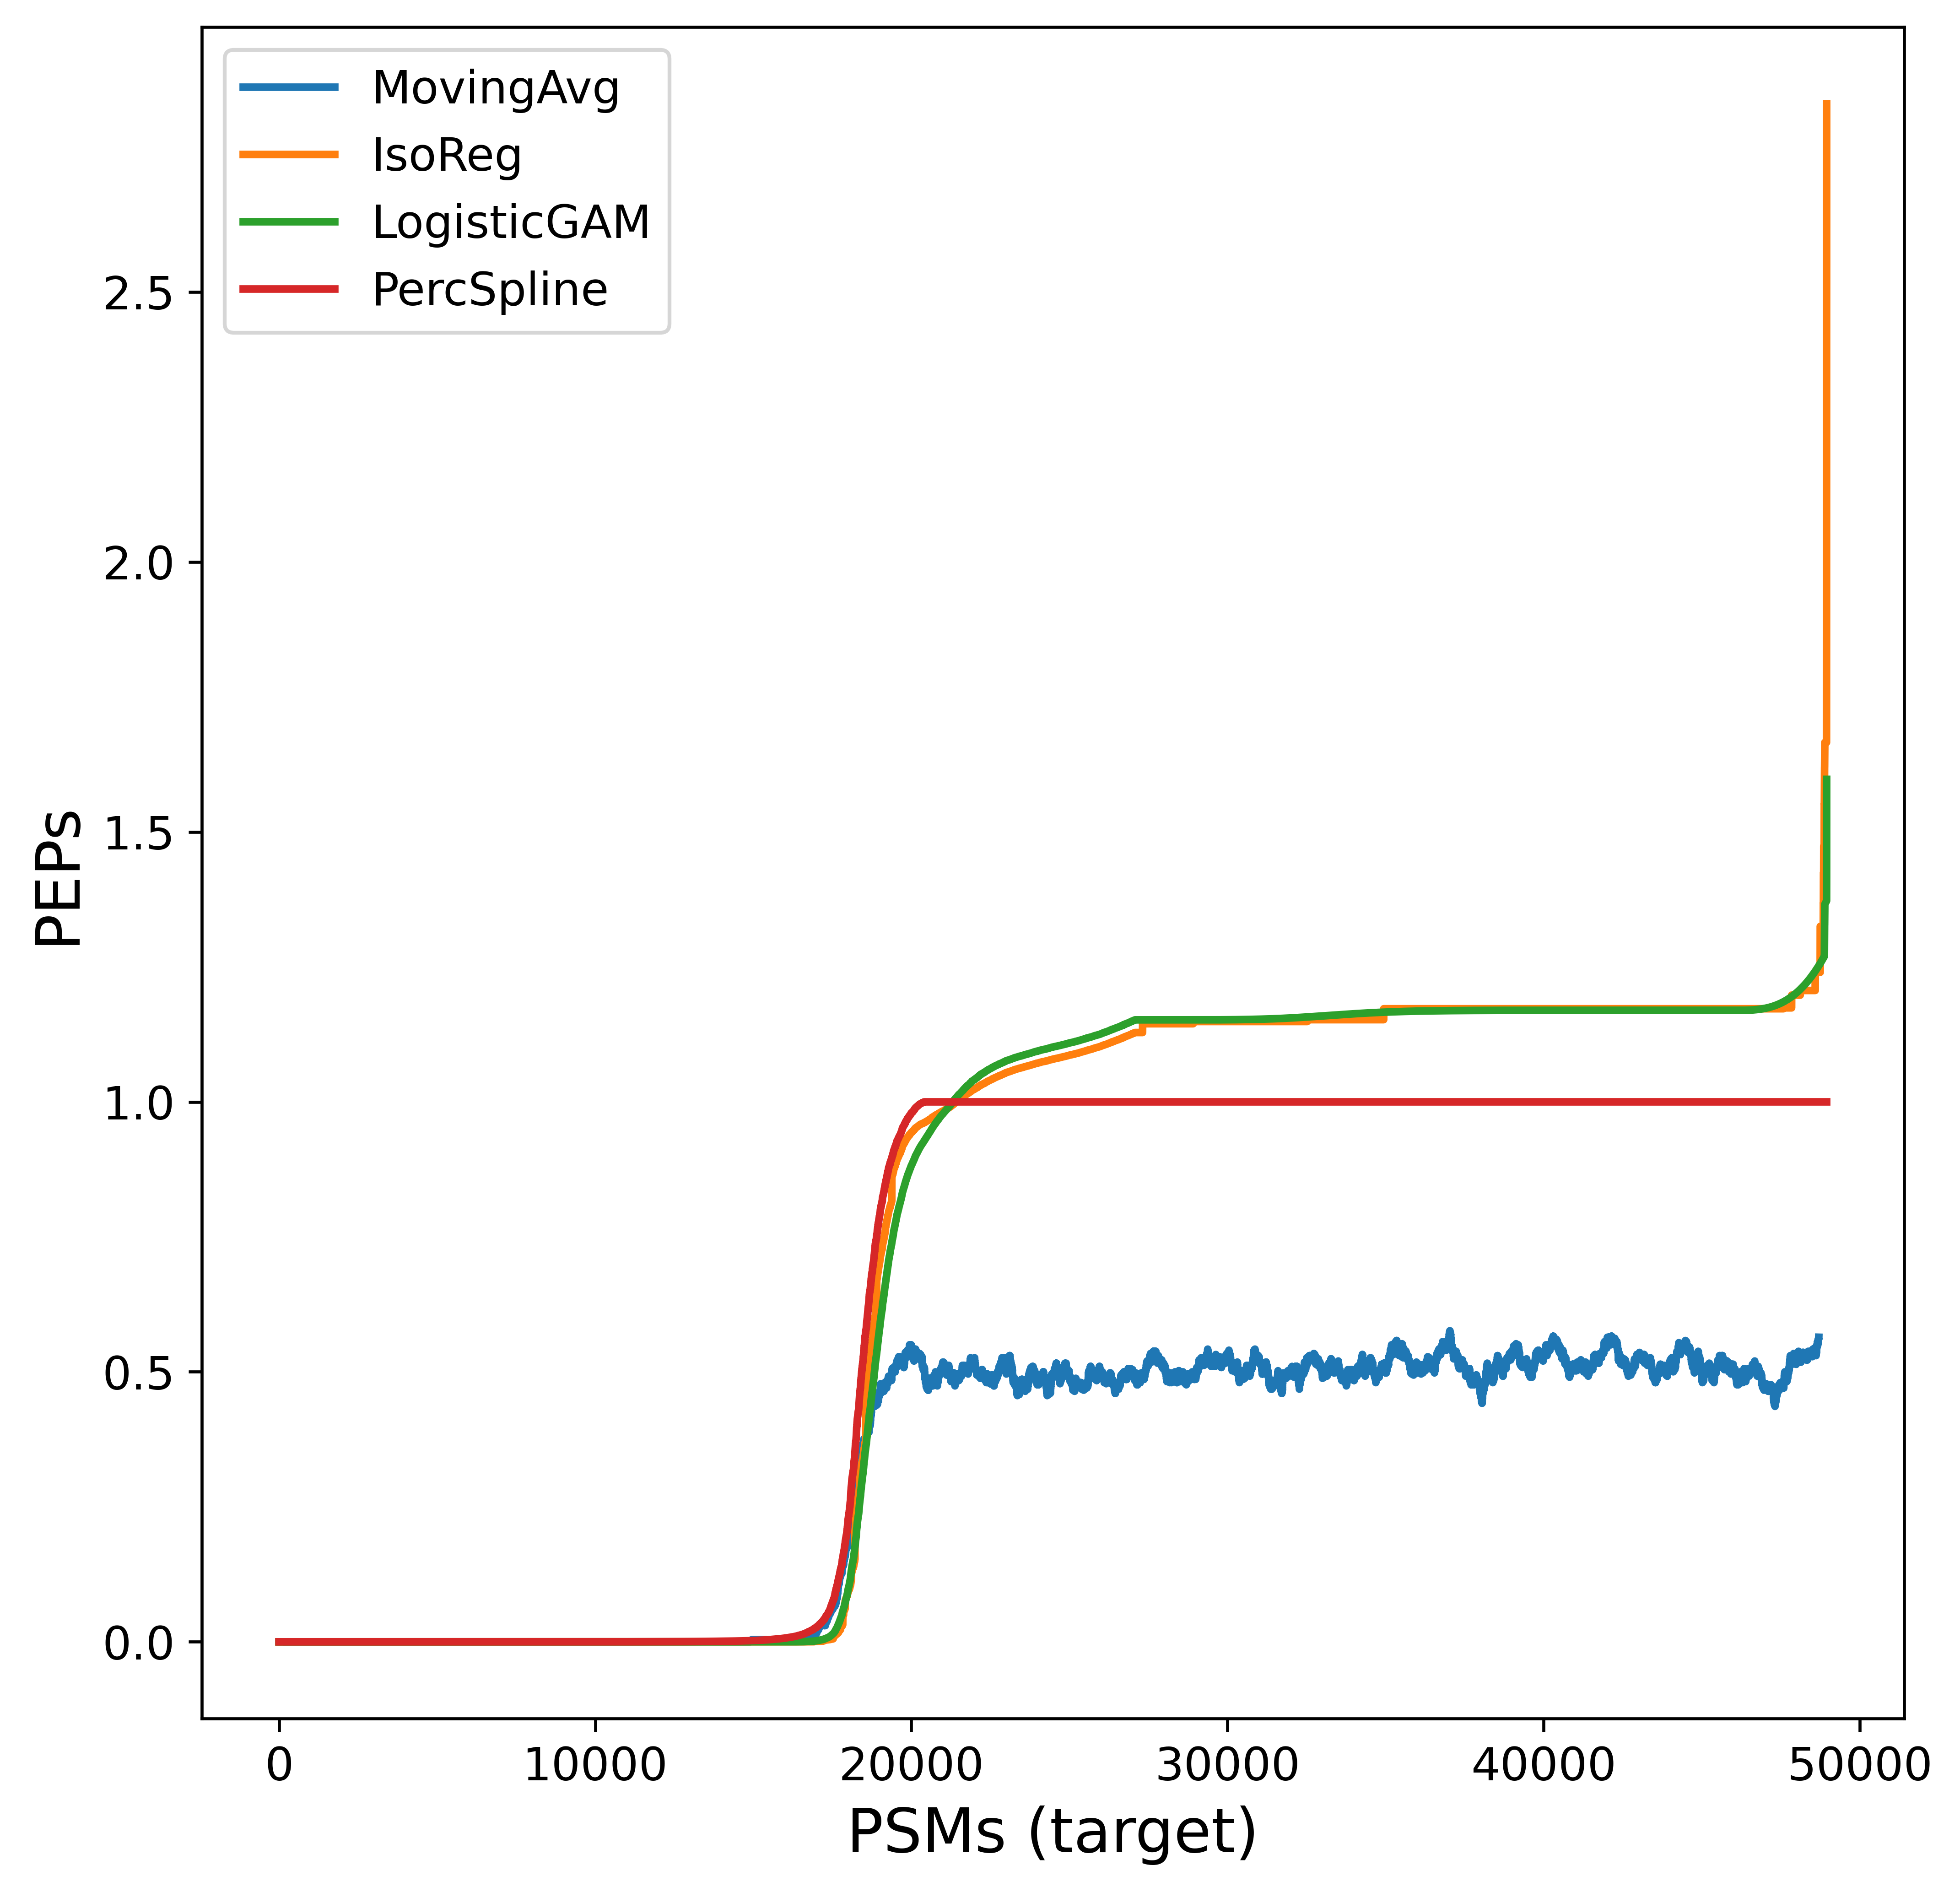

In [79]:
plt.figure(figsize=(8, 8), dpi=600)
xx = np.array(range(len(df["score"])))
plt.plot(xx, y_moving_avg, label="MovingAvg", linewidth=2)
plt.plot(xx, df["pep_isoreg"], label="IsoReg", linewidth=2)
plt.plot(xx, df["pep_logisticgam"], label="LogisticGAM", linewidth=2)
plt.plot(xx, df["pep_percspline"], label="PercSpline", linewidth=2)
plt.xlabel("PSMs (target)", fontsize=16)
plt.ylabel("PEPs", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [80]:
def estimate_q(df, col):
    df.index += 1
    df[f"q_{col}"] = df[f"pep_{col}"].cumsum() / df.index
    return df
df = df[df["type"] == 0]
df = estimate_q(df, "isoreg")
df = estimate_q(df, "logisticgam")
df = estimate_q(df, "percspline")

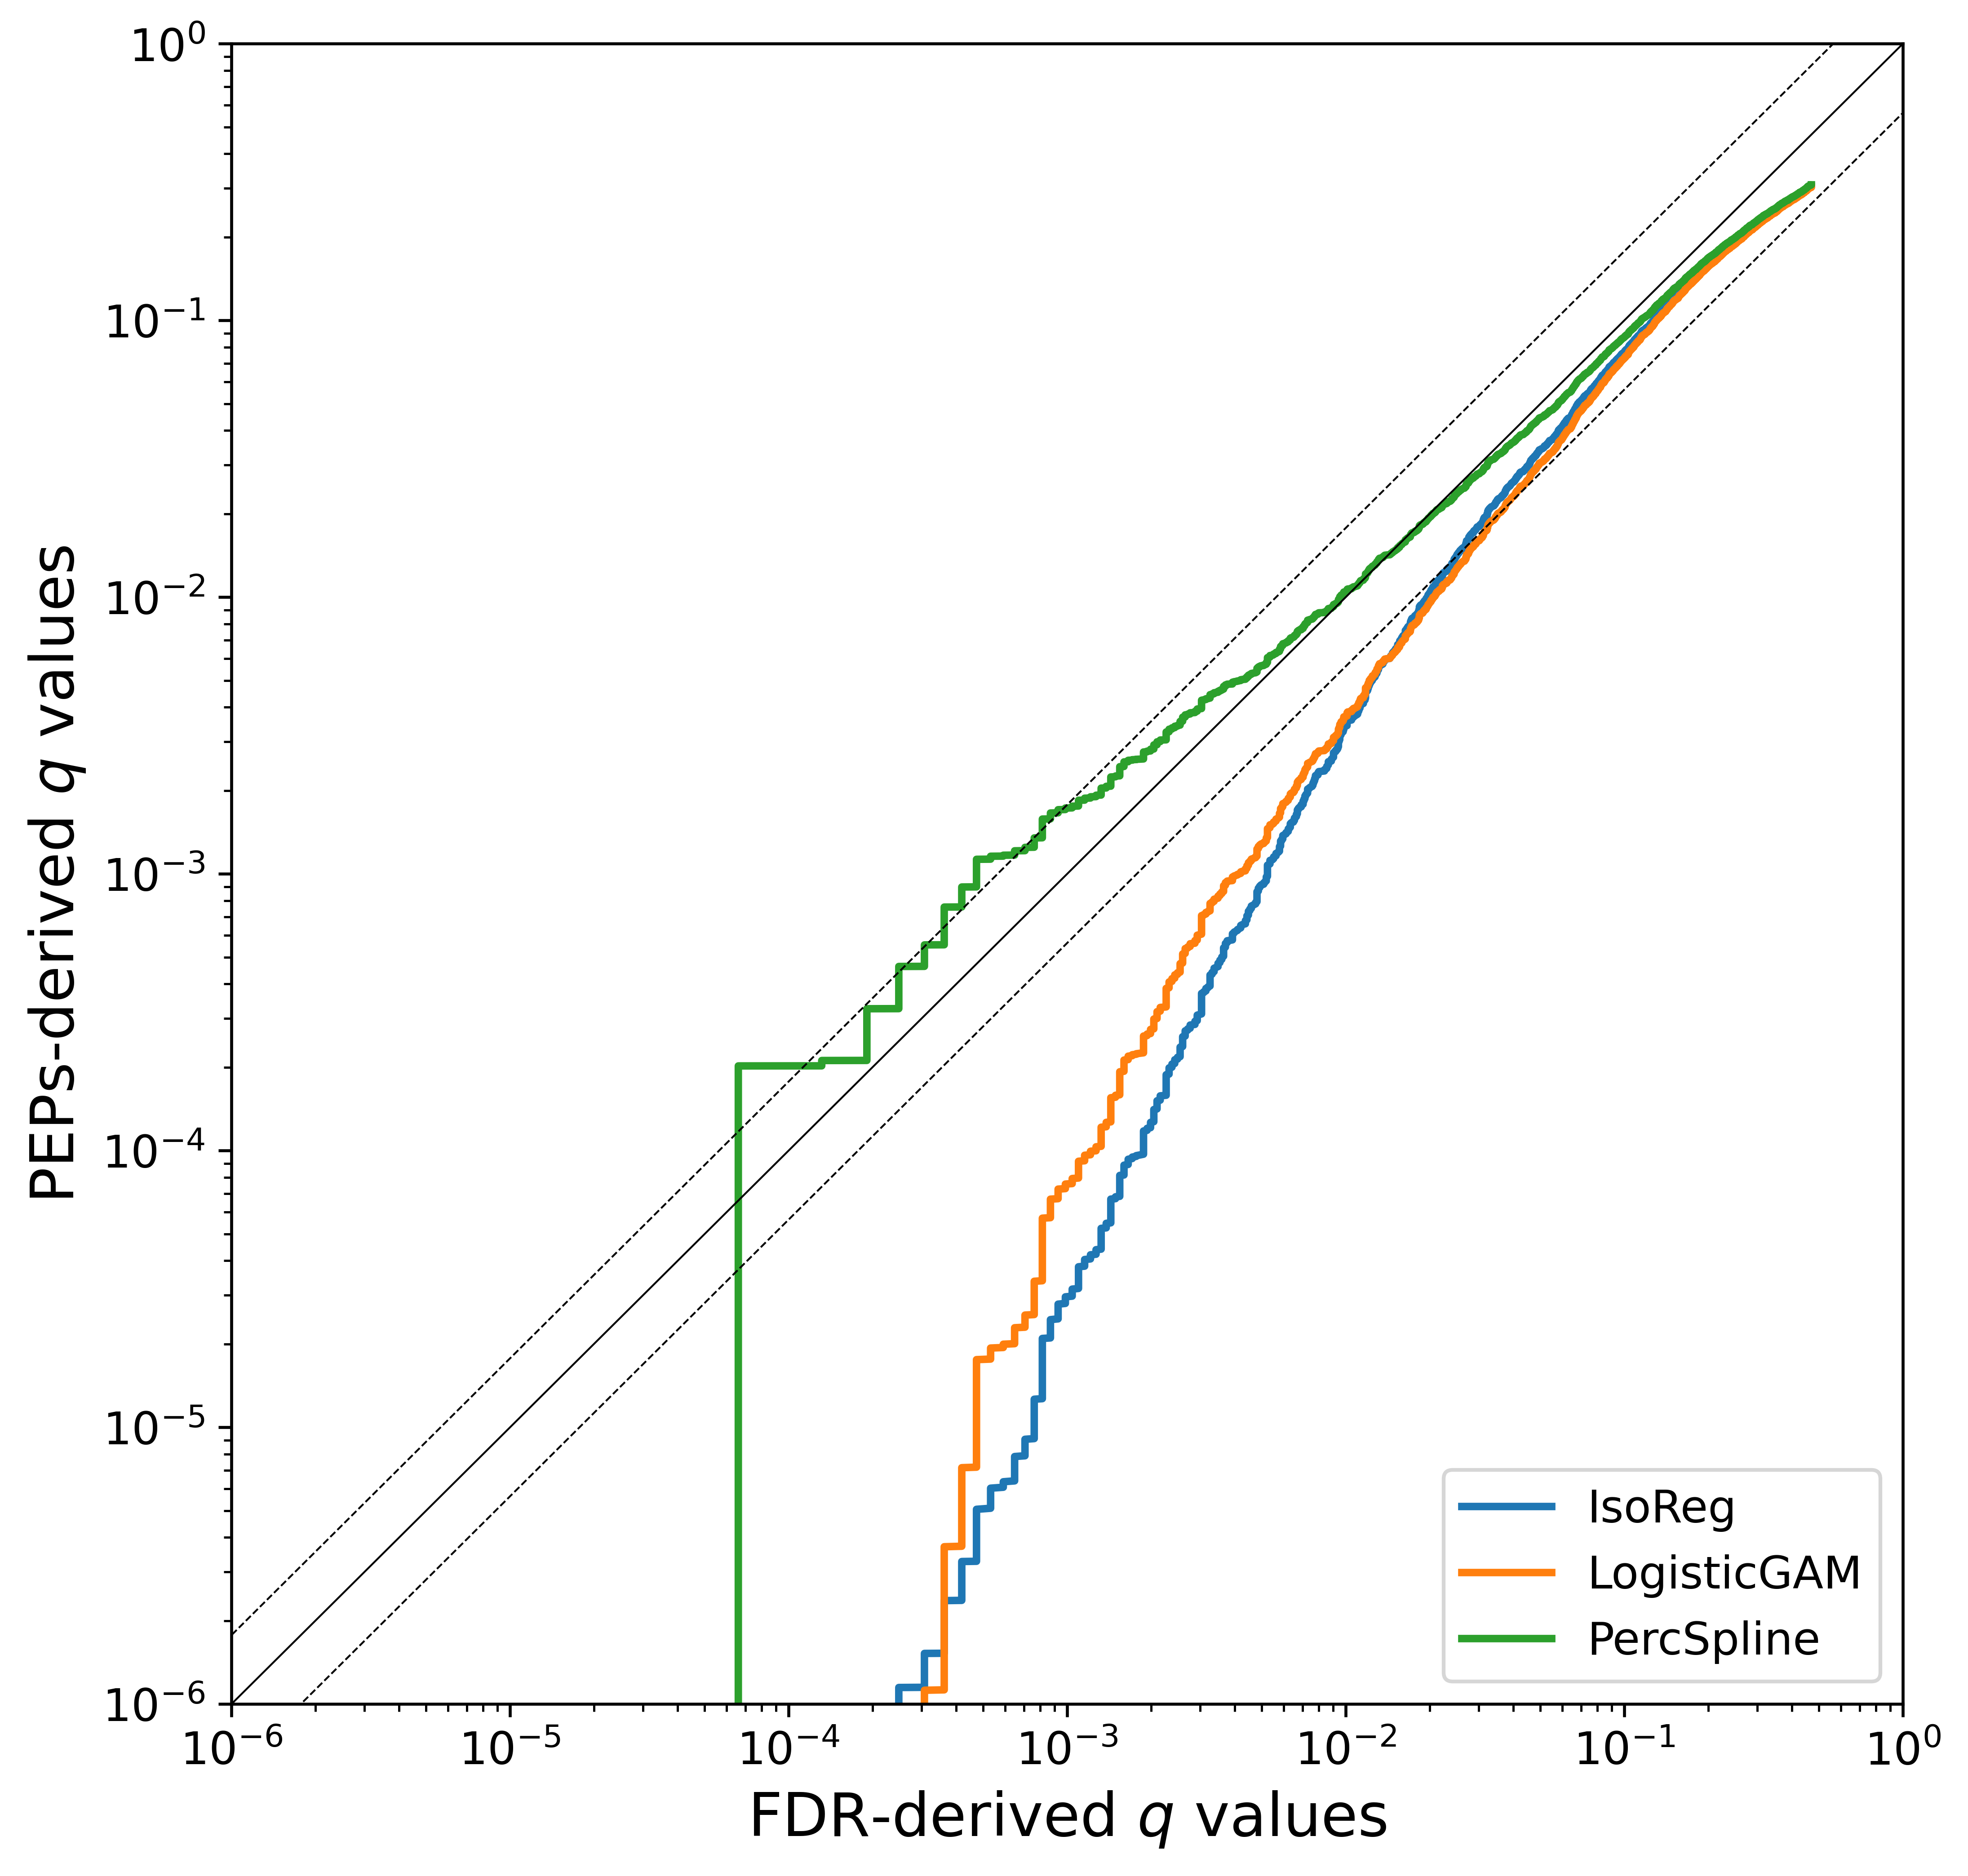

In [73]:
plt.figure(figsize=(8, 8), dpi=600)
plt.plot(df["q-value"], df[f"q_isoreg"], label="IsoReg", linewidth=2)
plt.plot(df["q-value"], df[f"q_logisticgam"], label="LogisticGAM", linewidth=2)
plt.plot(df["q-value"], df[f"q_percspline"], label="PercSpline", linewidth=2)

a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.000001, 1)
plt.ylim(0.000001, 1)
plt.show()